**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

*All the text in italics is instructions for filling the template - remove when writing the project report!*

# *Title* 

*Title should be concise and informative, describes the approach to solve the problem. Some good titles from previous years:*

*- Comparing extreme learning machines and naive bayes’ classifier in spam detection*

*- Using linear discriminant analysis in spam detection*

*Some not-so-good titles:*

*- Bayesian spam filtering with extras*

*- Two-component classifier for spam detection*

*- CS-E3210 Term Project, final report*




## Abstract

*Precise summary of the whole report, previews the contents and results. Must be a single paragraph between 100 and 200 words.*



## 1. Introduction

*Background, problem statement, motivation, many references, description of
contents. Introduces the reader to the topic and the broad context within which your
research/project fits*

*- What do you hope to learn from the project?*
*- What question is being addressed?*
*- Why is this task important? (motivation)*

*Keep it short (half to 1 page).*



## 2. Data analysis

*Briefly describe data (class distribution, dimensionality) and how will it affect
classification. Visualize the data. Don’t focus too much on the meaning of the features,
unless you want to.*

*- Include histograms showing class distribution.*



(2182, 264)


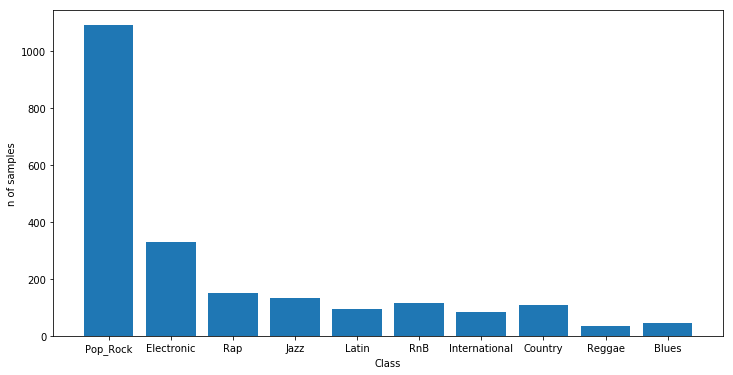

In [142]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
scaler = StandardScaler()

test_data = pd.read_csv("./test_data.csv", header=None).values
train_data = pd.read_csv("./train_data.csv", header=None).values
train_labels = pd.read_csv("./train_labels.csv", header=None).values
# Use every second item of train_data as confirmation data set and every second as training set
scaler.fit(train_data[::2])
confirm_set = scaler.transform(train_data[1::2])
confirm_labels = np.ravel(train_labels[1::2])
train_set = scaler.transform(train_data[::2])
train_labels = np.ravel(train_labels[::2])
test_data = scaler.transform(test_data)


classes = [
    "Pop_Rock",
    "Electronic",
    "Rap",
    "Jazz",
    "Latin",
    "RnB",
    "International",
    "Country",
    "Reggae",
    "Blues"
]
unique, counts = np.unique(train_labels, return_counts=True)
print(train_set.shape)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
hist = ax.bar(classes, counts)
ax.set_xlabel("Class")
ax.set_ylabel("n of samples")
plt.show()

In [144]:
# Load the data and cleanup

# CLF.fit Takes to parameters data X shape(n_samples, n_features) and labels Y shape(n_samples
def train_clf_with_params(solver, alpha, hidden_layer_sizes, random_state, X, Y):
    clf = MLPClassifier(solver=solver, alpha=alpha, hidden_layer_sizes=hidden_layer_sizes, random_state=random_state, shuffle=True)
    clf.fit(X, Y)
    return clf

def test_clf(clf, X, Y_true):
    Y_pred = clf.predict(X)
    score = clf.score(X, Y_true)
    Y_pred_proba = clf.predict_proba(X)
    loss = log_loss(Y_true, Y_pred_proba)
    return (score, loss, Y_pred)
    

def OneVsRest(X,y):
    svm = LinearSVC()
    clf = CalibratedClassifierCV(svm) 
    clf.fit(X, y)
    return clf

def testOneVsRest(clf, X, Y_true):
    predictions = clf.predict(X)
    Y_pred = clf.predict(X)
    score = clf.score(X, Y_true)
    Y_pred_proba = clf.predict_proba(X)
    loss = log_loss(Y_true, Y_pred_proba)
    return (score, loss, Y_pred)

def train_log_reg(X, Y):
    clf = LogisticRegression()
    clf.fit(X, Y)
    return clf


def cross_cv_clf(clf, X, Y_true):
    scores = cross_val_score(clf, X, Y_true, cv=5)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

def test_log_reg(clf, X, Y_true):
    predictions = clf.predict(X)
    Y_pred = clf.predict(X)
    score = clf.score(X, Y_true)
    Y_pred_proba = clf.predict_proba(X)
    loss = log_loss(Y_true, Y_pred_proba)
    
    return (score, loss, Y_pred)


In [146]:
#Analysis of the input data
# ...
#MLPC
mean = int(np.mean([train_set.shape[1], 10]))
# TEST MLC
datalen = 200
data2 = np.random.randint(1, high=train_set.shape[1], size=datalen)
data1 = [
    (15, )
]
data = [
    (mean, ),
    (161, 150),
    (161, 20),
    (150, ),
    (161, ),
    (2, 226),
    (220, 109),
    (15, 10),
    (144, )
]
best_loss = 100
best_score = 0
best_score_val = 0
best_loss_val = 0
best_score_clf = None
best_loss_clf = None
print("Starting iteration")
for i in data:
    clf = train_clf_with_params(s, 1e-5, i, 1, train_set, train_labels)
    cross_cv_clf(clf, train_set, train_labels)
    score, loss, predictions = test_clf(clf, confirm_set, confirm_labels)
    if (score > best_score):
        best_score = score
        best_score_val = (i, s)
        best_score_clf = clf
    if (best_loss > loss):
        best_loss = loss
        best_loss_val = (i, s)
        best_loss_clf = clf
print("LOSS " + str(best_loss))
print("VALUE " + str(best_loss_val))
print("SCORE " + str(best_score))
print("VALUE " + str(best_score_val))

#One vs rest
X, y = train_set, train_labels
clf = OneVsRest(X,y)
(score, loss, pred) = testOneVsRest(clf, confirm_set, confirm_labels)
print("OneVsRest")
print("Score: " + str(score))
print("log_loss: " + str(loss))
cross_cv_clf(clf, train_set, train_labels)
if (score > best_score):
    best_score = score
    best_score_val = (i, s)
    #best_score_clf = clf
if (best_loss > loss):
    best_loss = loss
    best_loss_val = (i, s)
    #best_loss_clf = clf
    
clf = train_log_reg(X,y)
(score, loss, pred) =test_clf(clf, confirm_set, confirm_labels)
print("Logistic regression")
print("Score: " + str(score))
print("log_loss: " + str(loss))
cross_cv_clf(clf, train_set, train_labels)
if (score > best_score):
    best_score = score
    best_score_val = (i, s)
    best_score_clf = clf
if (best_loss > loss):
    best_loss = loss
    best_loss_val = (i, s)
    best_loss_clf = clf

log_loss_predictions = best_loss_clf.predict_proba(test_data)
score_predictions = best_score_clf.predict(test_data)

Starting iteration
Accuracy: 0.58 (+/- 0.04)
Accuracy: 0.58 (+/- 0.01)
Accuracy: 0.59 (+/- 0.03)
Accuracy: 0.59 (+/- 0.04)
Accuracy: 0.58 (+/- 0.07)
Accuracy: 0.53 (+/- 0.05)
Accuracy: 0.59 (+/- 0.06)
Accuracy: 0.51 (+/- 0.06)
Accuracy: 0.58 (+/- 0.05)
LOSS 1.9471384024923806
VALUE ((2, 226), 'lbfgs')
SCORE 0.5955983493810179
VALUE ((220, 109), 'lbfgs')
OneVsRest
Score: 0.5891792755616689
log_loss: 1.2901627946349985
Accuracy: 0.58 (+/- 0.02)
Logistic regression
Score: 0.6235671710224667
log_loss: 1.3440332207684802
Accuracy: 0.63 (+/- 0.04)


## 3. Methods and experiments

*- Explain your whole approach (you can include a block diagram showing the steps in your process).* 

*- What methods/algorithms, why were the methods chosen. *

*- What evaluation methodology (cross CV, etc.).*



In [141]:
# Trials with ML algorithms
log_loss_headers = [
    "Class_1",
    "Class_2",
    "Class_3",
    "Class_4",
    "Class_5",
    "Class_6",
    "Class_7",
    "Class_8",
    "Class_9",
    "Class_10",
]
print(log_loss_predictions.shape)
log_loss_predictions = pd.DataFrame(log_loss_predictions)
score_predictions = pd.DataFrame(score_predictions)
score_predictions.index = range(1,len(score_predictions)+1)
log_loss_predictions.index = range(1,len(log_loss_predictions)+1)
score_predictions.to_csv("./score_results.csv", index_label="Sample_id", header=["Sample_label"])
log_loss_predictions.to_csv("./log_loss_results.csv", index_label="Sample_id", header=log_loss_headers)

(6544, 10)


## 4. Results

*Summarize the results of the experiments without discussing their implications.*

*- Include both performance measures (accuracy and LogLoss).*

*- How does it perform on kaggle compared to the train data.*

*- Include a confusion matrix.*



In [5]:
#Confusion matrix ...

## 5. Discussion/Conclusions

*Interpret and explain your results *

*- Discuss the relevance of the performance measures (accuracy and LogLoss) for
imbalanced multiclass datasets. *

*- How the results relate to the literature. *

*- Suggestions for future research/improvement. *

*- Did the study answer your questions? *



## 6. References

*List of all the references cited in the document*

## Appendix
*Any additional material needed to complete the report can be included here. For example, if you want to keep  additional source code, additional images or plots, mathematical derivations, etc. The content should be relevant to the report and should help explain or visualize something mentioned earlier. **You can remove the whole Appendix section if there is no need for it.** *